In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from torch.utils.data.dataset import Dataset
import pandas as pd
import torch
import ast
from torchvision.io import read_image
import os


In [ ]:
import cv2
import numpy as np

In [ ]:
csv_path = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/Dataset/dataset.csv"
img_path = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/Dataset/Images"

In [ ]:
with tf.device('/cpu:0'):  
  class CoinDataset(Dataset):
    """Euro Coin dataset."""

    def __init__(self, csv_file, root_dir, width, height,transforms=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.coin_frame = pd.read_csv(csv_file, header = None)
        print("Dataset caricato correttamente numero immagini:",len(self.coin_frame))
        self.root_dir = root_dir
        self.transforms = transforms 
        self.height = height
        self.width = width
        self.classes = [_, '10_cent']

    def getClass(self):
      return len(self.classes)

    def __len__(self):
        return len(self.coin_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.coin_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        label = torch.tensor(ast.literal_eval(self.coin_frame.iloc[idx, 1]))
        box = torch.tensor(ast.literal_eval(self.coin_frame.iloc[idx, 2])).unsqueeze(0)
        sample = {'image': image, 'label': label, 'box' : box} 

        area = (box[:, 3] - box[:, 1]) * (box[:, 2] - box[:, 0])
        iscrowd = torch.zeros((box.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = sample['box'] 
        target['labels'] =  sample['label']
        target['area'] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])

        if self.transforms:
              
              sample = self.transforms(image = img_res,
                                      bboxes = target['boxes'],
                                      labels = sample['label'])
              
              img_res = sample['image']
              target['boxes'] = torch.Tensor(sample['bboxes'])
              
              
              
        return img_res, target
    
  dataset = CoinDataset(csv_path, img_path, 150 ,150)
      

In [ ]:


%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision


cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 335227, done.
remote: Counting objects: 100% (51301/51301), done.
remote: Compressing objects: 100% (802/802), done.
remote: Total 335227 (delta 50676), reused 50974 (delta 50475), pack-reused 283926
Receiving objects: 100% (335227/335227), 674.00 MiB | 34.61 MiB/s, done.
Resolving deltas: 100% (308733/308733), done.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import cv2

from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

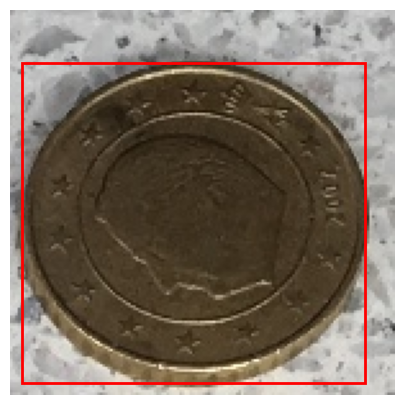

In [ ]:
def plot_img_bbox(img, target):
    
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    a.axis('off')
    plt.show()
    
img, target = dataset[25]
plot_img_bbox(img, target)

# Model

In [ ]:
def get_object_detection_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:

def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset =  CoinDataset(csv_path, img_path, 150, 150, transforms= get_transform(train=True))
dataset_test =  CoinDataset(csv_path, img_path, 150, 150, transforms= get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

model = get_object_detection_model(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 89.0MB/s]


In [ ]:
print(model.state_dict)

<bound method Module.state_dict of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(25

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/49]  eta: 0:10:15  lr: 0.000109  loss: 0.9417 (0.9417)  loss_classifier: 0.7704 (0.7704)  loss_box_reg: 0.1618 (0.1618)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 12.5643  data: 2.4792  max mem: 8197
Epoch: [0]  [10/49]  eta: 0:01:47  lr: 0.001150  loss: 0.4429 (0.5582)  loss_classifier: 0.2735 (0.3986)  loss_box_reg: 0.1529 (0.1526)  loss_objectness: 0.0030 (0.0033)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 2.7605  data: 0.2455  max mem: 8357
Epoch: [0]  [20/49]  eta: 0:01:07  lr: 0.002190  loss: 0.3154 (0.4259)  loss_classifier: 0.1761 (0.2728)  loss_box_reg: 0.1461 (0.1461)  loss_objectness: 0.0037 (0.0043)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 1.8077  data: 0.0269  max mem: 8357
Epoch: [0]  [30/49]  eta: 0:00:41  lr: 0.003231  loss: 0.1955 (0.3431)  loss_classifier: 0.0443 (0.1951)  loss_box_reg: 0.1326 (0.1408)  loss_objectness: 0.0053 (0.0049)  loss_rpn_box_reg: 0.0014 (0.0023)  time: 1.8761  data: 0.0353  max mem: 8357
Epoch: 

# Salvataggio del modello e dei pesi

In [ ]:
path_chekPoint = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/CheckPoint/model_checkpoint_10_cent_prova.pth"
path_weights = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/Weights/weights_10_cent.pth"
path_model =  "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/CheckPoint/faster_rcnn.onnx"

In [ ]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 61.5 MB/s eta 0:00:00


In [ ]:
import onnx
input = torch.randn(1, 3, 150, 150)
print(input.shape)
torch.onnx.export(model, input.cuda(), path_model, export_params=True, opset_version = 17, input_names = ['image'], output_names = ['boxes', 'labels', 'scores'])
